In [2]:
# Imports and scripts
#import pandas as pd
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import pathmagic
%matplotlib inline
with pathmagic.context():
    import Preprocess as Prep
    import RelativePaths as RP
    import Evaluation as Eva
    import Graphs
    import Utils
    import GatherData as Gather
import ray
ray.init(ignore_reinit_error=True)
Gather.gather_team_mates_data()

2021-03-26 11:01:41,044	INFO worker.py:666 -- Calling ray.init() again after it has already been called.


To request implementation, send an email to feature_requests@modin.org.


Text(0.5, 1.0, 'Shows the number of files for every label, from JabRef')

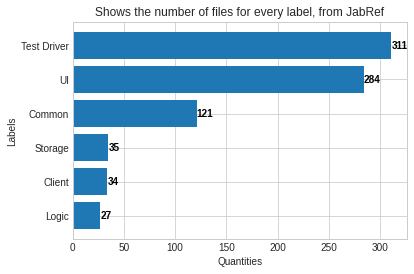

In [3]:
dataset_df = pd.read_csv(str(RP.getRawDataSet()))
y_labels = dataset_df.Label.unique()
x_quantity = [len(dataset_df.loc[dataset_df['Label']==label]) for label in y_labels]
tmp_df = pd.DataFrame({
    'Labels' : y_labels,
    'Quantity' : x_quantity
})
tmp_df = tmp_df.sort_values(by=['Quantity'])
plt.style.use("seaborn-whitegrid")
plt.barh(y=tmp_df.Labels, width=tmp_df.Quantity)
for i, v in enumerate(tmp_df.Quantity):
    plt.text(v, i, str(v), color='black', fontweight='bold', ha='left', va='center')

plt.xlabel('Quantities')
plt.ylabel('Labels')
plt.title('Shows the number of files for every label, from JabRef')

In [ ]:
test_file = '../Data/test.csv'
"""
settings matrix
"""
# maxent 
s0 = [
    ['lib', 'tow', 'jk', 'scw','lc', 'stem'],
    ['pac', 'tow', 'jk'],
    ]

s1 = [
    ['lib', 'tow', 'jk', 'scw','lc', 'stem'],
    ['pac',  'tow', 'jk'],
    ['com', 'tow', 'jk', 'scw', 'lc', 'sw'],
]

# Interestting results
s2 = [
    ['lib', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['pac', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['pm', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['pv', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['com', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['c', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
]

s3 = [
    ['pac', 'tow', 'jk'],
    ['lib', 'tow', 'scw', 'jk', 'lc', 'stem'],
    ['pm', 'tow', 'scw', 'jk', 'lc', 'sw'],
]
s4 = [ 
    ['lib', 'tow', 'scw', 'jk', 'lc', 'stem'],
    ['pac', 'tow', 'jk',],
    ['c', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['pm', 'tow', 'scw', 'jk', 'lc', 'sw', 'stem'],
    ['pv', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
]
s5 = [
    ['lib', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['pac', 'tow', 'jk'],
    ['pm', 'tow', 'jk', 'scw','lc', 'sw'],
    ['pv', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['com', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['c', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
]
s6 = [
    ['lib', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['pac', 'tow', 'jk'],
    ['pm', 'tow', 'jk', 'scw','lc', 'sw'],
    ['pv', 'tow', 'jk', 'scw','lc', 'sw'],
    ['com', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['c', 'tow', 'jk', 'scw','lc', 'sw'],
]
s7 = [
    ['lib', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['pac', 'tow', 'jk'],
    ['pm', 'tow', 'jk', 'scw','lc' ],
    ['pv', 'tow', 'jk', 'scw','lc' ],
    ['com', 'tow', 'jk', 'scw','lc', 'sw', 'stem'],
    ['c', 'tow', 'jk', 'scw','lc'],
]

settings_matrix = [s0, s1, s2, s3, s4 ,s5, s6, s7]

In [ ]:
def make_datafram_row(metrics, setting: list, setting_id: int ):
    report = metrics.get_classification_report()
    quantity_table = metrics.quantity_table()
    setting_id = 's' + str(setting_id)
    row = {
        'classifier': [metrics.name],
        'setting_id': [setting_id],
        'settings': [setting],
        'accuracy': [report['accuracy']],
        'w_avg_precision': [report['weighted avg']['precision']],
        'w_avg_recall': [report['weighted avg']['recall']],
        'train_size': [quantity_table['Train'].sum()], 
        'test_size': [quantity_table['Test'].sum()], 
        'report_table': [metrics.total_report_table()] 
    }
    df_row = pd.DataFrame(row)
    return df_row

In [ ]:
df_columns = [
    'classifier',
    'setting_id',
    'settings', 
    'accuracy', 
    'w_avg_precision', 
    'w_avg_recall', 
    'train_size', 
    'test_size', 
    'report_table' 
]
main_table = pd.DataFrame(columns=df_columns)
test_size=0.9
fold_quantity = 10

for index, setting in enumerate(settings_matrix):
    Prep.preprocess_settings(setting, test_file)
    test_df = pd.read_csv(test_file)

    # Remove GLOBALS and CLI from the dataset
    df_sliced = Utils.remove_concerns_under_quantity_threshold(test_df)

    feature_representation = CountVectorizer()
    confusion_list = []

    # Train and gather evaluation metrics
    evaluate = Eva.Evaluation(df_sliced, feature_representation, test_size, fold_quantity, 10)
    classifier_max_ent , metrics_max_ent = evaluate.evaluate_MaxEnt()
    classifier_svm , metrics_svm = evaluate.evaluate_SVM()
    classifier_naive, metrics_naive = evaluate.evaluate_Naive_Bayes()
    
    
    df_row = make_datafram_row(metrics_max_ent, setting, index)
    main_table = main_table.append(df_row)

    df_row = make_datafram_row(metrics_svm, setting, index)
    main_table = main_table.append(df_row)
    
    df_row = make_datafram_row(metrics_naive, setting, index)
    main_table = main_table.append(df_row)

main_table = main_table.reset_index(drop=True)
main_table.to_csv('../Data/analysis.csv')

In [ ]:
main_table

In [ ]:
print(main_table)

df = pd.read_csv('../Data/analysis.csv')
df.sort_values(by='accuracy',ascending=[False])